# Notebook : 02_model_training_unet.ipynb
- Objectif : entraîner un premier modèle U-Net sur Cityscapes (8 classes) avec pipeline MLOps

# 1 - Imports & préparation

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from keras import layers
from dotenv import load_dotenv
load_dotenv()

False

In [2]:
# Remonter à la racine du projet
project_root = Path("..").resolve()

# Ajouter src/ au PYTHONPATH
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

# Chemins utiles
data_dir      = project_root / "data"
processed_dir = data_dir / "processed"
models_dir    = project_root / "models"

train_path = processed_dir / "train.npz"
val_path   = processed_dir / "val.npz"

## 1.1 - Chargement de la fonction d'entraînement MLOps-compliant

In [3]:
# from src.model_training.train_unet import train_unet_model
from model_training.train_unet import train_unet_model

## 1.2 - Chargement des données .npz

In [4]:
train = np.load(train_path)
val   = np.load(val_path)

In [5]:
X_train, Y_train = train["X"], train["Y"]
X_val, Y_val     = val["X"], val["Y"]

## 1.3 - Paramètres de test rapide (dev agile ou prod, suivant contexte)
### 1.3.1 - Taille réduite pour test rapide - 71 min 50 sec

In [6]:
params_test = {
    'img_size': (128, 128),
    'epochs': 10,
    'batch_size': 4,
    'use_early_stopping': True,
    'force_retrain': False
}

### 1.3.2 - Full training pour mise en production

In [ ]:
# params_prod = {
#     'img_size': (256, 256),           # Taille standard Cityscapes réduite
#     'epochs': 50,                     # Entraînement complet
#     'batch_size': 8,                  # Bon compromis CPU/RAM
#     'use_early_stopping': True,      # Pour éviter l’overfitting
#     'force_retrain': False           # Ne réentraîne que si modèle absent
# }

In [ ]:
params_grid = [
    {
        'img_size': (256, 256),
        'epochs': 30,
        'batch_size': 4,
        'use_early_stopping': True,
        'force_retrain': True
    },
    {
        'img_size': (256, 256),
        'epochs': 40,
        'batch_size': 8,
        'use_early_stopping': True,
        'force_retrain': True
    },
    {
        'img_size': (256, 256),           # Taille standard Cityscapes réduite
        'epochs': 50,                     # Entraînement complet
        'batch_size': 8,                  # Bon compromis CPU/RAM
        'use_early_stopping': True,      # Pour éviter l’overfitting
        'force_retrain': True 
    },
    {
        'img_size': (256, 256),
        'epochs': 50,
        'batch_size': 16,
        'use_early_stopping': True,
        'force_retrain': True
    }
]

# 2 - Entraînement du modèle (ou chargement si déjà existant)
- changer params_test ou params_prod, suivant le besoin

In [ ]:
results = []

for i, params in enumerate(params_grid):
    print(f"\n🔁 Lancement de l'entraînement {i+1}/{len(params_grid)} avec batch={params['batch_size']}, epochs={params['epochs']}")

    model, history = train_unet_model(
        X_train, Y_train,
        X_val, Y_val,
        **params
    )

    val_acc = max(history.history['val_accuracy'])
    val_loss = min(history.history['val_loss'])

    results.append({
        'run': i+1,
        'params': params,
        'val_accuracy': val_acc,
        'val_loss': val_loss,
        'model': model,
        'history': history
    })

In [ ]:
# # params = params_test
# params = params_prod

# model, history = train_unet_model(
#     X_train, Y_train,
#     X_val, Y_val,
#     force_retrain = params['force_retrain'],
#     img_size = params['img_size'],
#     epochs = params['epochs'],
#     batch_size = params['batch_size'],
#     use_early_stopping = params['use_early_stopping']
# )

🔄 Lancement du serveur MLflow local...
✅ Serveur MLflow démarré sur http://127.0.0.1:5000
[LOG] ➤ train_unet_model appelé
[INFO] Modèle déjà existant. Chargement...




## 2.1 - Sélection du meilleur run

In [ ]:
best_run = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)[0]

print(f"\n✅ Meilleur modèle : Run {best_run['run']} avec val_accuracy = {best_run['val_accuracy']:.4f}")
best_model = best_run['model']
best_history = best_run['history']

# 3 - Résumé du modèle

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

# 4 - Évaluation graphique

In [10]:
def plot_history(history):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.title("Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='acc')
    plt.plot(history['val_accuracy'], label='val_acc')
    plt.title("Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

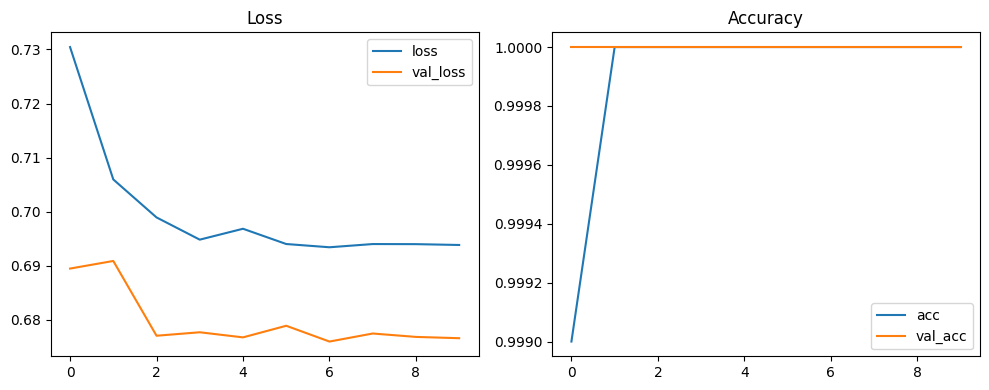

In [11]:
plot_history(history)